<a href="https://colab.research.google.com/github/W-C-G/ProjectRepository/blob/main/Excercise_Motion_Classification_AI_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Excercise Motion Classification AI Competition**


[Subject & Background] 
* Develop Excercise Motion Recognition Algorithm
* Data Analysis Method(adaptable to Smart Healthcare Field)




[Competition Description]


*   Development of excercise motion recognition alorithm by applying machine learning algorithm to sensor data measured using 3-axis accelerometer and 3-axis gyroscope.


[Host] Dacon

[Calendar] 2021.01.11 ~ 2021.02.22 17:59

[Development Environment] Google Colab

---

# **Using Library**



---



In [1]:
from google.colab import drive
import os

import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Convolution2D, MaxPooling2D, ConvLSTM2D, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization

import matplotlib.pyplot as plt



---
# **Data Loading**
---

In [2]:
# Mount from my google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check directory
os.chdir('/content/drive/MyDrive/월간 11 운동')

In [4]:
train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

---
# **Data Check**
---

In [5]:
# confirm 600 data per id
train['id'].value_counts()

2047    600
1347    600
2378    600
1354    600
2379    600
       ... 
1699    600
675     600
2722    600
1698    600
0       600
Name: id, Length: 3125, dtype: int64

In [6]:
# confirm motion from id and lables in train_labels.csv
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


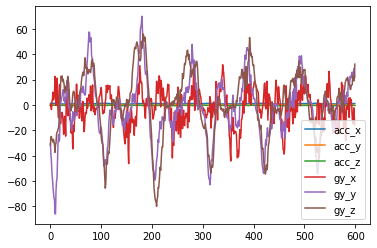

In [7]:
# confirm motions flow per id 
ex=train[train['id']==0]
ex.iloc[:,2:].plot()

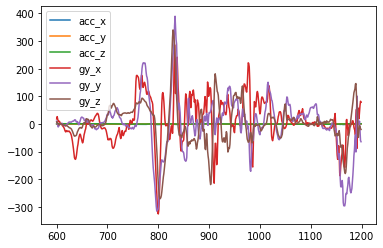

In [8]:
ex=train[train['id']==1]
ex.iloc[:,2:].plot()

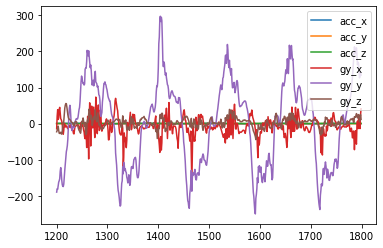

In [9]:
ex=train[train['id']==2]
ex.iloc[:,2:].plot()

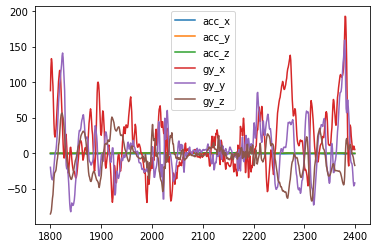

In [10]:
ex=train[train['id']==3]
ex.iloc[:,2:].plot()

In [11]:
# submission form
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---
# **Data Update**
---

In [12]:
# extract the train data into a 1 dimension matrix, and data update
# -1 : from source array length(= 3125, train data id)
# 600 : 600 data per id
# 6: 3 axis * 2

X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6, 1])
X.shape

TensorShape([3125, 600, 6, 1])

In [13]:
# extract categorized train_labels. As a result, it is saved in the form of one-hot code.
# ex) id = 0, label = 37  ====> [0, 0, 0, ...1(index = 37), 0, 0, ...0]
# ex) id = 1, label = 26  ====> [0, 0, ...1(index = 26), 0, 0, 0, ...0]
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(3125, 61)

---
# **Model & Training**
---

In [14]:
########################### CNN + LSTM model #####################################
model = Sequential()

# CNN 1
model.add(Convolution2D(32, (3, 3), activation = 'relu', input_shape = (600, 6, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# CNN2
model.add(Convolution2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# CNN3
model.add(Convolution2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D((1, 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Reshape((149, 64)))
model.add(LSTM(32))

# # flatten
model.add(Flatten())

# dense layer add
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 4, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 299, 2, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 299, 2, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 2, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 2, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 1, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 1, 64)        0

In [15]:
# Prevent Overfitting by using early stopping
early_stopping = EarlyStopping(monitor='loss', patience = 30, mode='auto')

hist = model.fit(X, y, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
79/79 [==============================] - 12s 27ms/step - loss: 3.0670 - accuracy: 0.4490 - val_loss: 2.6988 - val_accuracy: 0.4976
Epoch 2/300
79/79 [==============================] - 1s 13ms/step - loss: 2.6233 - accuracy: 0.4804 - val_loss: 2.4254 - val_accuracy: 0.4992
Epoch 3/300
79/79 [==============================] - 1s 13ms/step - loss: 2.4027 - accuracy: 0.4916 - val_loss: 2.2844 - val_accuracy: 0.5248
Epoch 4/300
79/79 [==============================] - 1s 13ms/step - loss: 2.2855 - accuracy: 0.5030 - val_loss: 2.2143 - val_accuracy: 0.5488
Epoch 5/300
79/79 [==============================] - 1s 13ms/step - loss: 2.1255 - accuracy: 0.5315 - val_loss: 2.1836 - val_accuracy: 0.5440
Epoch 6/300
79/79 [==============================] - 1s 13ms/step - loss: 2.1307 - accuracy: 0.5054 - val_loss: 1.9574 - val_accuracy: 0.5536
Epoch 7/300
79/79 [==============================] - 1s 14ms/step - loss: 1.9524 - accuracy: 0.5379 - val_loss: 1.9762 - val_accuracy: 0.5648
Epoch

In [16]:
# Accuracy Comparison about CNN+LSTM Model
score = model.evaluate(X, y, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

98/98 [==============================] - 1s 8ms/step - loss: 0.8024 - accuracy: 0.8205
Train score: 0.8024088144302368
Train accuracy: 0.8204799890518188


---
# **Visualization of Result**

---



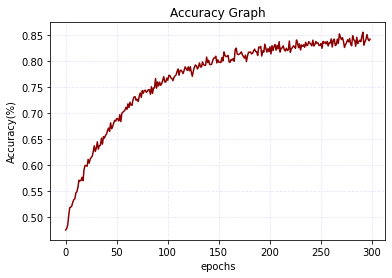

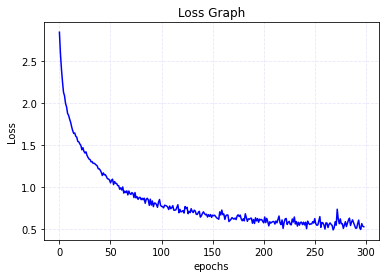

<Figure size 432x288 with 0 Axes>

In [18]:
val_loss = hist.history['loss']
val_acc = hist.history['accuracy']

fig = plt.figure()

# Accuracy Graph
plt.plot(range(299), val_acc, label='Accuracy', color='darkred')

plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
plt.title('Accuracy Graph')
plt.grid(linestyle='--', color='lavender')

plt.show()
plt.savefig('deep_learning_acc.png')

# Loss Graph
plt.plot(range(299), val_loss, label='Loss', color='blue')

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.grid(linestyle='--', color='lavender')

plt.show()
plt.savefig('deep_learning_loss.png')

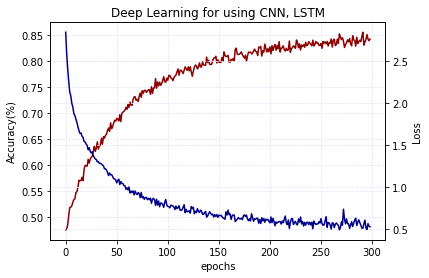

No handles with labels found to put in legend.


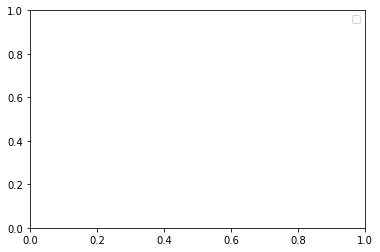

In [19]:
fig = plt.figure()

ax_acc = fig.add_subplot()

# Accuracy Graph
ax_acc.plot(range(299), val_acc, label='Accuracy(%)', color='darkred')

plt.title('Deep Learning for using CNN, LSTM')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

# Loss Graph
ax_loss = ax_acc.twinx()
ax_loss.plot(range(299), val_loss, label='Loss', color='darkblue')
plt.ylabel('Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

plt.show()
plt.legend()

---
# **Submission**
---

In [20]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 600, 6, 1])
prediction=model.predict(test_X)

In [21]:
submission.iloc[:,1:] = prediction
submission.to_csv('CNN 3 layer_lstm add.csv', index=False)

In [22]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,1.239812e-09,7.172367e-05,3.318829e-12,1.764092e-09,1.180230e-04,1.496266e-06,7.919518e-01,1.435215e-09,2.203510e-10,2.014691e-02,1.036522e-02,2.884685e-05,1.128010e-08,1.049759e-03,3.530932e-06,4.000186e-09,2.139748e-06,1.167683e-05,7.607116e-07,1.311856e-12,1.095428e-08,2.474049e-07,9.069271e-11,7.136722e-09,5.855222e-05,1.615786e-06,0.000225,2.509740e-05,7.823003e-11,1.059416e-09,1.270621e-01,1.592105e-02,8.848788e-09,1.955860e-04,5.111852e-04,1.648601e-13,2.042698e-05,1.491653e-02,4.701956e-10,3.235288e-09,1.157246e-06,7.568795e-06,1.265738e-04,1.064483e-04,3.489517e-09,2.165253e-05,1.382540e-07,1.696892e-02,3.614731e-08,1.266544e-09,1.206370e-06,2.624744e-08,1.200369e-08,7.765494e-09,1.256510e-05,3.670206e-11,1.055053e-05,8.676528e-09,5.150390e-05,2.720355e-06,1.686053e-09
1,3126,1.290947e-06,1.895309e-07,1.847574e-13,5.841211e-08,2.446368e-06,1.364618e-09,1.949721e-08,1.598362e-07,2.846067e-12,1.104225e-08,6.808489e-09,1.665616e-11,2.505582e-17,3.224423e-14,1.405478e-08,2.317129e-06,3.553544e-13,6.275777e-14,6.075468e-10,2.761534e-13,3.487050e-11,3.706517e-08,9.991887e-07,1.067676e-06,8.098928e-08,9.306811e-09,0.999615,3.992255e-10,1.135832e-15,1.972405e-13,3.291215e-09,7.516402e-12,1.313167e-08,3.799876e-08,6.055483e-08,6.831491e-08,4.232556e-08,1.008570e-08,1.268855e-13,4.922654e-18,9.670725e-09,1.295809e-09,1.065941e-07,1.240511e-07,1.119905e-07,3.317142e-09,7.825642e-11,1.831246e-06,4.278615e-06,1.562214e-04,2.128348e-04,1.145324e-10,2.217818e-16,3.451764e-12,3.700142e-10,1.092101e-10,5.350003e-08,4.161141e-07,7.274043e-11,1.312829e-12,1.398841e-07
2,3127,2.187631e-05,5.298808e-03,2.422213e-04,3.895105e-03,1.145820e-03,1.480562e-04,1.268594e-02,1.691290e-04,7.274134e-03,1.231831e-02,8.637943e-03,2.726171e-02,1.631634e-04,2.123720e-03,2.437326e-02,4.943626e-03,5.497325e-04,7.826952e-04,5.220074e-04,1.957224e-05,2.203735e-04,6.398522e-03,3.100562e-05,1.179070e-04,7.658631e-02,9.262910e-05,0.072966,7.488561e-03,6.595784e-04,8.006376e-04,3.155552e-03,1.441353e-03,9.654622e-04,2.155582e-02,3.004271e-03,5.920646e-05,9.332747e-03,8.759675e-03,2.215122e-03,2.037265e-05,3.761399e-04,4.643653e-04,1.107586e-02,2.418084e-02,5.867494e-03,4.486061e-01,8.360094e-05,6.046822e-02,2.243767e-02,3.725591e-04,3.440455e-03,1.013099e-03,2.643321e-04,9.202508e-05,6.025988e-02,1.197967e-03,5.396090e-04,1.831000e-04,7.445798e-03,8.357734e-05,2.309939e-02
3,3128,3.168435e-09,9.705374e-09,2.052970e-13,4.797306e-11,4.868584e-09,2.703775e-10,1.010405e-08,4.005439e-12,1.614028e-12,8.391903e-09,2.244250e-06,4.124070e-10,5.082967e-22,7.693541e-14,1.850768e-11,3.429532e-08,1.100394e-13,1.503861e-11,4.339580e-11,3.190346e-12,6.489452e-12,1.248931e-09,1.885679e-13,9.807243e-08,3.957814e-09,7.577195e-11,0.999930,1.957243e-09,1.181481e-16,1.050547e-15,6.236075e-08,3.134911e-12,5.816986e-08,2.030707e-07,9.925482e-11,1.845722e-09,8.373484e-09,3.976944e-09,2.639492e-16,2.372781e-20,1.660171e-10,6.928439e-12,7.677073e-12,2.348284e-09,1.576332e-12,1.278884e-10,4.528489e-10,1.942642e-09,2.266366e-09,1.146194e-06,6.616686e-05,7.524763e-13,4.140380e-20,2.498291e-13,4.702618e-10,1.790900e-11,4.030337e-09,9.388278e-08,8.605597e-11,7.999617e-15,6.656419e-09
4,3129,4.466873e-07,3.795093e-08,1.501615e-12,1.527436e-09,3.028254e-07,5.498769e-08,1.205576e-08,2.033693e-08,1.397338e-12,2.069195e-10,4.882521e-09,1.087286e-11,8.017857e-17,1.025877e-12,1.344235e-09,1.781245e-06,4.268671e-12,3.066282e-11,5.532959e-09,9.069715e-14,5.225621e-11,2.482538e-09,2.633924e-08,1.061579e-07,9.492037e-08,4.208982e-08,0.999443,1.764497e-10,2.155199e-15,1.400748e-13,2.880892e-10,7.115352e-12,5.093779e-09,1.277493e-07,7.581556e-07,2.387608e-08,5.785921e-08,1.383898e-09,9.792457e-14,1.097551e-17,3.473300e-08,4.699112e-09,4.399179e-08,5.605470e-08,4.257439e-10,1.528338e-10,2.666484e-10,9.330522e-08,8.867420e-08